In [1]:
# Import necessary libraries and modules

import os
import sys
# Ensure the project root is on the Python path for package imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from src.preprocessing import Preprocessor
from src.model import CampaignModel
from src.data_loader import DataLoader


In [2]:
# 1. Load data
data_path = os.path.join(PROJECT_ROOT, "customerGroups.csv")
df = DataLoader(data_path).load()
print(f"Data shape: {df.shape}")
df.head()

Data shape: (6620, 71)


,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
0,4.50,1,3,4,5,1,1,4,6,0,...,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76,2
1,2.20,24,22,46,10,24,28,18,22,-4,...,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85,1
2,12.00,7,4,11,18,8,11,2,10,-3,...,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05,2
3,1.91,8,5,13,14,6,7,6,9,-1,...,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82,0
4,2.50,23,16,39,14,33,25,18,27,8,...,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99,2


In [3]:
# 2. Basic data summary
df.info()
df.describe().T.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6620 entries, 0 to 6619
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   g1_1    6620 non-null   float64
 1   g1_2    6620 non-null   int64  
 2   g1_3    6620 non-null   int64  
 3   g1_4    6620 non-null   int64  
 4   g1_5    6620 non-null   int64  
 5   g1_6    6620 non-null   int64  
 6   g1_7    6620 non-null   int64  
 7   g1_8    6620 non-null   int64  
 8   g1_9    6620 non-null   int64  
 9   g1_10   6620 non-null   int64  
 10  g1_11   6620 non-null   int64  
 11  g1_12   6620 non-null   int64  
 12  g1_13   6620 non-null   float64
 13  g1_14   6620 non-null   float64
 14  g1_15   6620 non-null   float64
 15  g1_16   6620 non-null   float64
 16  g1_17   6620 non-null   float64
 17  g1_18   6620 non-null   float64
 18  g1_19   6620 non-null   float64
 19  g1_20   6620 non-null   float64
 20  g1_21   6620 non-null   float64
 21  g2_1    6620 non-null   float64
 22  

,count,mean,std,min,25%,50%,75%,max
g1_1,6620.0,2.708779,1.857725,1.05,1.667,2.15,2.8,23.0
g1_2,6620.0,14.424018,10.700787,0.00,6.000,13.00,21.0,52.0
g1_3,6620.0,10.485650,8.384203,0.00,4.000,9.00,15.0,47.0
g1_4,6620.0,24.909668,18.174948,0.00,10.000,22.00,36.0,94.0
g1_5,6620.0,10.988066,5.635985,1.00,6.000,11.00,16.0,20.0


In [4]:
# 2a. Missing value counts

null_counts = df.isnull().sum().sort_values(ascending=False)
display(null_counts[null_counts > 0])
print("Total columns with any missing values:", (null_counts > 0).sum())

Series([], dtype: int64)

Total columns with any missing values: 0


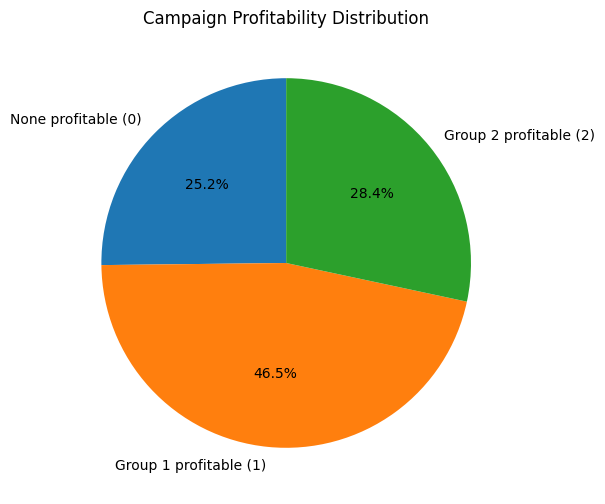

Percentage breakdown:
None profitable (0): 25.18%
Group 1 profitable (1): 46.47%
Group 2 profitable (2): 28.35%


In [5]:
# 3. Analyze campaign outcomes 
# ML Challenge Q1: Analyze the campaign results to determine 
# what percentage of campaigns led to group 1 being more profitable? 
# What about group 2? What percentage had neither group profitable?

target_counts = df['target'].value_counts(normalize=True).sort_index()
labels = ['None profitable (0)', 'Group 1 profitable (1)', 'Group 2 profitable (2)']

plt.figure(figsize=(6,6))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Campaign Profitability Distribution")
plt.show()

print("Percentage breakdown:")
for i, lbl in enumerate(labels):
    print(f"{lbl}: {target_counts.iloc[i]*100:.2f}%")


In [6]:
# 4. Collect features before the campaign was run

def _within_numeric_suffix(column, prefix, limit):
    if not column.startswith(prefix) or '_' not in column:
        return False
    suffix = column.split('_', 1)[1]
    return suffix.isdigit() and int(suffix) <= limit

# variables g1_1 until g1_20 were known before the campaign was run
# variables g2_1 until g2_20 were known before the campaign was run
# variables c_1 until c_27 were known before the campaign was run
feature_cols = [
    c for c in df.columns
    if _within_numeric_suffix(c, 'g1_', 20)
    or _within_numeric_suffix(c, 'g2_', 20)
    or _within_numeric_suffix(c, 'c_', 27)
 ]

In [7]:
# 5. Feature Selection

X_all = df[feature_cols]
y_all = df['target']

# Remove highly correlated predictors to reduce redundancy
corr_threshold = 0.8
corr_matrix = X_all.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > corr_threshold)]
if high_corr_features:
    print(f"Dropping {len(high_corr_features)} features due to |corr| > {corr_threshold}:")
    print(high_corr_features)
X_uncorr = X_all.drop(columns=high_corr_features) if high_corr_features else X_all

# Select features using mutual information importance threshold
importance_quantile = 0.75  # adjust to keep more or fewer features
mi_scores = pd.Series(mutual_info_classif(X_uncorr, y_all, random_state=42), index=X_uncorr.columns)
mi_threshold = mi_scores.quantile(importance_quantile)
selected_features = mi_scores[mi_scores >= mi_threshold].index.tolist()

if not selected_features:
    fallback_k = min(5, len(mi_scores))
    selected_features = mi_scores.sort_values(ascending=False).head(fallback_k).index.tolist()
    print(f"No features cleared the MI threshold; falling back to top {fallback_k} by score.")

top_features = mi_scores.loc[selected_features].sort_values(ascending=False)

print(f"Selected {len(selected_features)} features with MI >= {mi_threshold:.4f} (quantile={importance_quantile}):")
display(top_features.to_frame(name="MI_score"))
print("Selected feature names:")
print(list(selected_features))

feature_cols = list(selected_features)

Dropping 26 features due to |corr| > 0.8:
['g1_3', 'g1_4', 'g1_6', 'g1_8', 'g1_9', 'g1_12', 'g1_13', 'g1_14', 'g1_16', 'g1_19', 'g2_3', 'g2_4', 'g2_6', 'g2_8', 'g2_9', 'g2_12', 'g2_13', 'g2_14', 'g2_18', 'c_12', 'c_17', 'c_18', 'c_19', 'c_20', 'c_21', 'c_26']
Selected 11 features with MI >= 0.0340 (quantile=0.75):


,MI_score
c_2,0.130470
g1_1,0.109558
g2_1,0.088416
c_6,0.052309
c_3,0.051388
c_10,0.050315
c_25,0.048938
c_11,0.042285
g2_19,0.036351
g2_11,0.035471


Selected feature names:
['g1_1', 'g1_5', 'g2_1', 'g2_11', 'g2_19', 'c_2', 'c_3', 'c_6', 'c_10', 'c_11', 'c_25']


In [8]:
# 6. Train-Test split data and preprocessing

X = df[feature_cols]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessor applies median imputation followed by standardization (zero mean / unit variance)
pre = Preprocessor()
X_train_prep = pre.fit_transform(X_train)
X_test_prep = pre.transform(X_test)

X_train_prep = pd.DataFrame(X_train_prep, columns=feature_cols)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_cols)


Target distribution in train vs. test:


,Train,Test
target,,
0,0.251888,0.251511
1,0.464690,0.464502
2,0.283421,0.283988


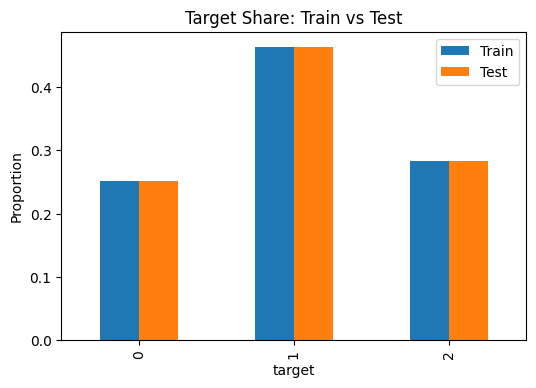

In [9]:
# 6a. Train/test distribution check

train_dist = y_train.value_counts(normalize=True).sort_index()
test_dist = y_test.value_counts(normalize=True).sort_index()
drift_df = pd.DataFrame({"Train": train_dist, "Test": test_dist})
print("Target distribution in train vs. test:")
display(drift_df)
drift_df.plot(kind='bar', figsize=(6,4))
plt.title("Target Share: Train vs Test")
plt.ylabel("Proportion")
plt.show()


In [10]:
# 7. Train all model tiers with class balancing
models = ["dummy", "rf", "ada", "gbm", "xgb", "cat"]
results = []
best_model = None
best_model_name = None
best_preds = None
best_cm = None
best_report = None
best_score = -np.inf

for mtype in models:
    print("=" * 60)
    print(f"Training model: {mtype.upper()}")
    # CampaignModel picks the right estimator, injects class weights, and logs CV F1 before refitting
    model = CampaignModel(mtype, balance_classes=True)
    # train() performs stratified 5-fold CV with sample weights, then refits on full data
    model.train(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    acc = accuracy_score(y_test, preds)

    # For multi-class and imbalanced dataset, macro F1 treats all classes evenly, 
    # so performance on the rare group (e.g., “Group 2 profitable”) counts just as much as the majority class. 
    # Accuracy alone could look fine even if a model ignores the minority class, but macro F1 will drop sharply in that scenario.
    f1 = f1_score(y_test, preds, average="macro")
    prec = precision_score(y_test, preds, average="macro", zero_division=0)
    rec = recall_score(y_test, preds, average="macro", zero_division=0)
    try:
        proba = model.predict_proba(X_test_prep)
        # For multi-class AUC, use one-vs-rest (ovr) approach computes the AUC of each class against all other classes
        auc = roc_auc_score(y_test, proba, multi_class="ovr")
    except AttributeError:
        auc = np.nan
    results.append({
        "Model": mtype.upper(),
        "Accuracy": acc,
        "F1_macro": f1,
        "Precision_macro": prec,
        "Recall_macro": rec,
        "AUC_ovr": auc,
    })

    if f1 > best_score:
        best_score = f1
        best_model = model
        best_model_name = mtype.upper()
        best_preds = preds
        best_cm = confusion_matrix(y_test, preds)
        best_report = classification_report(y_test, preds, zero_division=0)

print("=" * 60)
print(f"Best model (macro F1): {best_model_name}")

results_df = pd.DataFrame(results).sort_values("F1_macro", ascending=False).reset_index(drop=True)
display(results_df.round({"Accuracy": 4, "F1_macro": 4, "Precision_macro": 4, "Recall_macro": 4, "AUC_ovr": 4}))

2025-11-11 11:57:26,048 - INFO - [dummy] CV F1_macro: 0.1445


Training model: DUMMY
Training model: RF


2025-11-11 11:57:32,270 - INFO - [rf] CV F1_macro: 0.4911


Training model: ADA


2025-11-11 11:57:47,815 - INFO - [ada] CV F1_macro: 0.5268


Training model: GBM


2025-11-11 11:58:56,704 - INFO - [gbm] CV F1_macro: 0.5205


Training model: XGB


2025-11-11 11:59:19,411 - INFO - [xgb] CV F1_macro: 0.4930


Training model: CAT


2025-11-11 11:59:37,203 - INFO - [cat] CV F1_macro: 0.4830


Best model (macro F1): ADA


,Model,Accuracy,F1_macro,Precision_macro,Recall_macro,AUC_ovr
0,ADA,0.5491,0.5270,0.5290,0.5293,0.7141
1,GBM,0.5619,0.5264,0.5248,0.5292,0.7087
2,XGB,0.5461,0.4979,0.4975,0.5032,0.6925
3,RF,0.5733,0.4936,0.5046,0.5110,0.6970
4,CAT,0.4804,0.4829,0.5154,0.4945,0.7054
5,DUMMY,0.4645,0.2114,0.1548,0.3333,0.5000


In [11]:
# 8. Soft voting ensemble of tree models
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
weight_map = dict(zip(class_labels, class_weights))
train_weights = y_train.map(weight_map).values

cat_params = {
    "iterations": 500,
    "learning_rate": 0.04,
    "depth": 6,
    "loss_function": "MultiClass",
    "random_seed": 42,
    "verbose": False,
    "allow_writing_files": False
}
ensemble_estimators = [
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=3, n_jobs=-1,
        random_state=42, class_weight=weight_map)),
    ("ada", AdaBoostClassifier(
        n_estimators=400, learning_rate=0.05, random_state=42)),
    ("gbm", GradientBoostingClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        random_state=42)),
    ("xgb", XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8,
        colsample_bytree=0.8, random_state=42, eval_metric='mlogloss')),
    ("cat", CatBoostClassifier(**cat_params, class_weights=[weight_map[c] for c in sorted(weight_map)]))
]
ensemble = VotingClassifier(estimators=ensemble_estimators, voting='soft', weights=[1, 1, 2, 2, 2], n_jobs=-1)
ensemble.fit(X_train_prep, y_train, sample_weight=train_weights)
ensemble_preds = ensemble.predict(X_test_prep)
ensemble_acc = accuracy_score(y_test, ensemble_preds)
ensemble_f1 = f1_score(y_test, ensemble_preds, average='macro')
ensemble_prec = precision_score(y_test, ensemble_preds, average='macro', zero_division=0)
ensemble_rec = recall_score(y_test, ensemble_preds, average='macro', zero_division=0)
ensemble_auc = roc_auc_score(y_test, ensemble.predict_proba(X_test_prep), multi_class="ovr")
results.append({"Model": "TREE_ENSEMBLE", "Accuracy": ensemble_acc, "F1_macro": ensemble_f1, "Precision_macro": ensemble_prec, "Recall_macro": ensemble_rec, "AUC_ovr": ensemble_auc})
print(f"TREE_ENSEMBLE metrics: Accuracy={ensemble_acc:.4f}, F1={ensemble_f1:.4f}, Precision={ensemble_prec:.4f}, Recall={ensemble_rec:.4f}, AUC={ensemble_auc:.4f}")

if ensemble_f1 > best_score:
    best_score = ensemble_f1
    best_model = CampaignModel("cat", balance_classes=True)
    best_model.model = ensemble
    best_model.model_type = "ensemble"
    best_model_name = "TREE_ENSEMBLE"
    best_preds = ensemble_preds
    best_cm = confusion_matrix(y_test, ensemble_preds)
    best_report = classification_report(y_test, ensemble_preds, zero_division=0)

print("="*60)
print(f"Current best model after ensembling: {best_model_name}")


TREE_ENSEMBLE metrics: Accuracy=0.5604, F1=0.5263, Precision=0.5245, Recall=0.5289, AUC=0.7077
Current best model after ensembling: ADA


           Model  Accuracy  F1_macro  Precision_macro  Recall_macro   AUC_ovr
0          DUMMY  0.464502  0.211449         0.154834      0.333333  0.500000
1             RF  0.573263  0.493634         0.504566      0.511045  0.696971
2            ADA  0.549094  0.527014         0.529014      0.529273  0.714150
3            GBM  0.561934  0.526431         0.524765      0.529193  0.708658
4            XGB  0.546073  0.497878         0.497543      0.503236  0.692479
5            CAT  0.480363  0.482874         0.515441      0.494524  0.705376
6  TREE_ENSEMBLE  0.560423  0.526328         0.524483      0.528913  0.707692


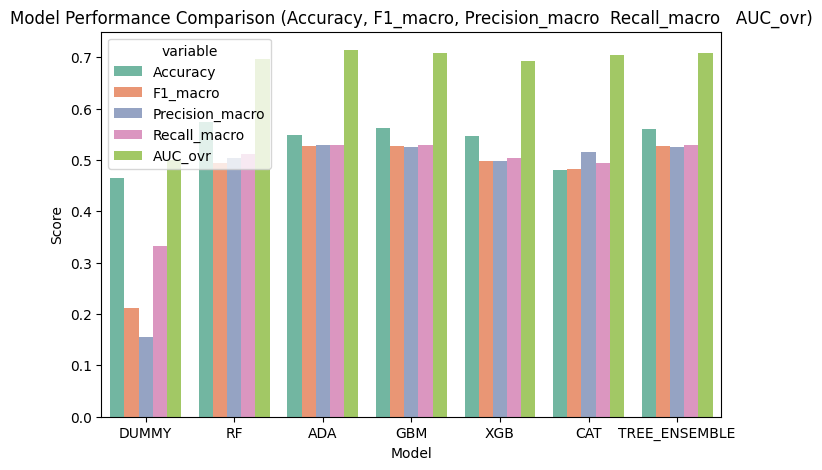

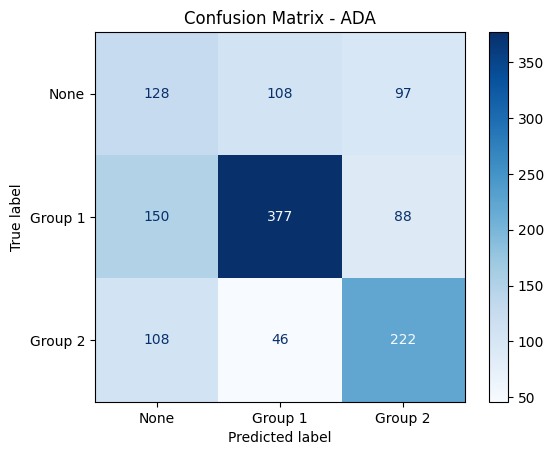

In [12]:
# 9. Compare model performance

res_df = pd.DataFrame(results)
print(res_df)

plt.figure(figsize=(8,5))
sns.barplot(data=res_df.melt("Model"), x="Model", y="value", hue="variable", palette="Set2")
plt.title("Model Performance Comparison (Accuracy, F1_macro, Precision_macro  Recall_macro   AUC_ovr)")
plt.ylabel("Score")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["None", "Group 1", "Group 2"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [13]:
# 10. Hyperparameter tuning for AdaBoost (after identifying it as a top performer)
ada_param_grid = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.03, 0.05, 0.1]
}
ada_search = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid=ada_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)
ada_search.fit(X_train_prep, y_train)
ada_best_params = ada_search.best_params_
ada_best_score = ada_search.best_score_
print("Best AdaBoost params:", ada_best_params)
print(f"Cross-validated F1_macro: {ada_best_score:.4f}")

ada_tuned_model = CampaignModel("ada", balance_classes=True, params=ada_best_params)
ada_tuned_model.train(X_train_prep, y_train)
ada_tuned_preds = ada_tuned_model.predict(X_test_prep)
ada_tuned_acc = accuracy_score(y_test, ada_tuned_preds)
ada_tuned_f1 = f1_score(y_test, ada_tuned_preds, average="macro")
ada_tuned_prec = precision_score(y_test, ada_tuned_preds, average="macro", zero_division=0)
ada_tuned_rec = recall_score(y_test, ada_tuned_preds, average="macro", zero_division=0)
try:
    ada_tuned_proba = ada_tuned_model.predict_proba(X_test_prep)
    ada_tuned_auc = roc_auc_score(y_test, ada_tuned_proba, multi_class="ovr")
except AttributeError:
    ada_tuned_auc = np.nan

print("AdaBoost tuned metrics:")
print({
    "Accuracy": round(ada_tuned_acc, 4),
    "F1_macro": round(ada_tuned_f1, 4),
    "Precision_macro": round(ada_tuned_prec, 4),
    "Recall_macro": round(ada_tuned_rec, 4),
    "AUC_ovr": round(ada_tuned_auc, 4),
})

Best AdaBoost params: {'learning_rate': 0.05, 'n_estimators': 400}
Cross-validated F1_macro: 0.4592


2025-11-11 12:00:37,567 - INFO - [ada] CV F1_macro: 0.5268


AdaBoost tuned metrics:
{'Accuracy': 0.5491, 'F1_macro': 0.527, 'Precision_macro': 0.529, 'Recall_macro': 0.5293, 'AUC_ovr': 0.7141}


Estimated ROI improvement ≈ 23.4%


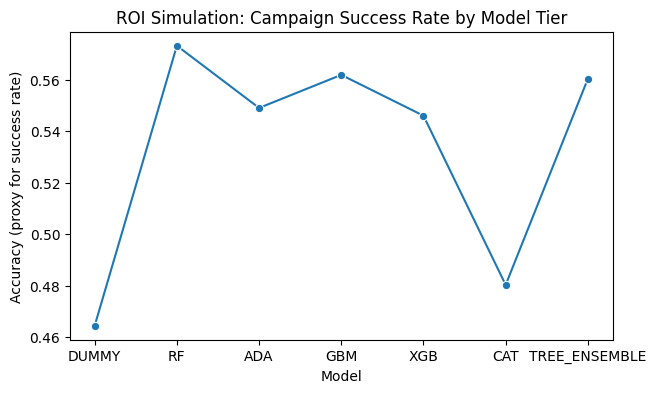

In [14]:
# 11. ROI improvement estimation 
# ML Challenge Q3: Estimate how much your model could improve the campaign success rate

baseline_acc = res_df.loc[res_df["Model"]=="DUMMY","Accuracy"].values[0]
best_acc = res_df["Accuracy"].max()
uplift = (best_acc - baseline_acc)/baseline_acc * 100
print(f"Estimated ROI improvement ≈ {uplift:.1f}%")

plt.figure(figsize=(7,4))
sns.lineplot(x=res_df["Model"], y=res_df["Accuracy"], marker="o")
plt.title("ROI Simulation: Campaign Success Rate by Model Tier")
plt.ylabel("Accuracy (proxy for success rate)")
plt.show()


In [15]:
# 13. Example prediction (API alignment)

sample = X_test.iloc[0:1]
sample_prep = pre.transform(sample)
sample_prep = pd.DataFrame(sample_prep, columns=feature_cols)
pred = best_model.predict(sample_prep)[0]
mapping = {0: "none profitable", 1: "group 1", 2: "group 2"}
print("Example prediction:", mapping[int(pred)])


Example prediction: group 1


In [16]:
# 14. Save model and preprocessor

best_model.save("../models/trained_model.pkl")
pre.save("../models/preprocessor.pkl")
print("Artifacts saved to ../models/")


Artifacts saved to ../models/


In [17]:
# 15. Summary

summary_df = res_df.sort_values("F1_macro", ascending=False).reset_index(drop=True)
print("Summary of Results:")
print(summary_df.round({"Accuracy": 4, "F1_macro": 4, "Precision_macro": 4, "Recall_macro": 4, "AUC_ovr": 4}))
print(f"\nROI improvement: {uplift:.1f}% over baseline")


Summary of Results:
           Model  Accuracy  F1_macro  Precision_macro  Recall_macro  AUC_ovr
0            ADA    0.5491    0.5270           0.5290        0.5293   0.7141
1            GBM    0.5619    0.5264           0.5248        0.5292   0.7087
2  TREE_ENSEMBLE    0.5604    0.5263           0.5245        0.5289   0.7077
3            XGB    0.5461    0.4979           0.4975        0.5032   0.6925
4             RF    0.5733    0.4936           0.5046        0.5110   0.6970
5            CAT    0.4804    0.4829           0.5154        0.4945   0.7054
6          DUMMY    0.4645    0.2114           0.1548        0.3333   0.5000

ROI improvement: 23.4% over baseline
